# Temporal Difference and Monte Carlo Learning

Temporal difference (TD) and Monte Carlo (MC) methods appear all over the place in reinforcement learning (RL). While they could seemingly not be more different, they really represent two sides of the same coin. This notebook will present two algorithms based on these approaches, show how to implement them in TensorFlow 2.0, and compare them on a simple prediction task. We will assume some basic familiarity with reinforcement learning, including knowledge of the agent-environment setup, states, rewards, and discounting.

## Introduction

Both TD-learning and MC-learning are really moreso paradigms or ideas than algorithms. For demonstration purposes, we will use two algorithms called TD-prediction and MC-prediction, though there are many other algorithms based on the same ideas. In both cases, the task is simple: we are in an environment and given some policy $\pi$. Our goal is to find or estimate the so-called value function $v_{\pi}$. This function represents the expected cumulative discounted reward that an agent will receive when starting in that state and taking actions following $\pi$.

$$
v_{\pi}(s) = \mathbb{E}_{\pi}\left[\sum_{k=0}^{\infty}\gamma^k R_{t+1+k} \mid S_t = s\right]
$$

We can rewrite the equation above slightly to obtain a recursive relationship between successive states.

$$
v_{\pi}(s) = \mathbb{E}_{\pi}\left[R_{t+1} + \gamma v_{\pi}(S') \mid S_t = s\right]
$$

$S'$ is a random variable denoting the successor state to $s$. This equation also known as (one of) the Bellman equation(s), and will turn out to be very useful in a second.

### TD-Prediction

The basic idea behind TD-prediction is simple. We start with some random estimate of the value function $\hat{v}_{\pi}$ with parameters $\theta$. While acting according to our policy, we then observe states, actions, and rewards, and use those to perform the following update.

$$
\theta \leftarrow \theta + \alpha \left[ R + \gamma \hat{v}_{\pi}(S') - \hat{v}_{\pi}(S) \right] \nabla \hat{v}_{\pi}(S)
$$

where the gradient is taken with respect to $\theta$. The variable $\alpha$ is called the *learning rate* and is just some small constant here, though it is not uncommon to decay it over time. This update attempts to narrow the difference between a states value and the *target* $R_{t+1} + \gamma v_{\pi}(S')$ at every step. Over time, the differences get smaller and smaller, and it is easy to see that the fixed point of these updates satisfies the Bellman equation from earlier! If reached, this would mean that we found the true value function.

Using Python and TensorFlow 2.0, we can implement this as follows. `policy` is a `tf.keras.Model` object that was assume to be given.

```python
for i in range(num_episodes):
    state = env.reset().reshape(1, -1)
    done = False
    while not done:
        action = np.random.choice(num_actions, p=policy(state))
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.reshape(1, -1)

        # Compute TD error
        if done:
            target = reward
        else:
            target = reward + gamma * value_fn(next_state)
        delta = target - value_fn(state)

        # Compute gradient
        weights = value_fn.trainable_weights
        with tf.GradientTape() as tape:
            value = value_fn(state)
        grads = tape.gradient(value, weights)

        # Update weights
        for w, g in zip(weights, grads):
            dw = tf.reshape(alpha * delta * g, w.shape)
            w.assign_add(dw)

        state = next_state
```

A full version can be found [here](https://github.com/christopher-wolff/rlsuite/blob/master/rlsuite/algos/semi_gradient_td_prediction.py).

### MC-Prediction

MC-prediction takes a different approach to the problem. Typically, updates are done on an episode-by-episode basis. We roll out an episode following $\pi$, and then compute the return $G_t$ at every time step as

$$
G_t = \sum_{k=0}^{\infty}\gamma^k R_{t+1+k}
$$

Recall this quantity from the definition of the value function earlier. The algorithm is shown as pythonic pseudo-code below. Then, we use the return to perform the update

$$
\theta \leftarrow \theta + \alpha \left[ G_t - \hat{v}_{\pi}(S) \right] \nabla \hat{v}_{\pi}(S)
$$

This looks similar to the TD update above, except that we update towards $G_t$ rather than $R_{t+1} + \gamma v_{\pi}(S')$. The corresponding Python code is shown below and a full version can be found [here](https://github.com/christopher-wolff/rlsuite/blob/master/rlsuite/algos/gradient_mc_prediction.py).

```python
for i in range(num_episodes):
    # Roll out an episode
    experience = []
    state = env.reset()
    done = False
    while not done:
        action = np.random.choice(num_actions, p=policy(state))
        next_state, reward, done, _ = env.step(action)
        experience.append((state, reward))
        state = next_state

    G = 0
    for state, reward in reversed(experience):
        # Convert state to one-element batch
        state = state.reshape(1, -1)

        # Compute return
        G = gamma * G + reward

        # Compute gradient
        weights = value_fn.trainable_weights
        with tf.GradientTape() as tape:
            value = value_fn(state)
        grads = tape.gradient(value, weights)

        # Update weights
        for w, g in zip(weights, grads):
            dw = tf.reshape(alpha * (G - value) * g, w.shape)
            w.assign_add(dw)
```

## Experiments

To see some of the differences between the two algorithms, we will conduct a simple experiment. The task is the following: the agent starts in the middle of a corridor, where it can move to the left and right. If it goes to the left, it will eventually reach the end, causing the episode to terminate with a total reward of $0$. If it goes to the right, the episode will also terminate, but in the final state it will achieve a reward of $+1$. The task is *undiscounted*, that is $\gamma = 1$.

<img src="imgs/random_walk.png" style="width: 500px"/>

<center>Image credit: Sutton & Barto (2018)</center>

The agent itself acts completely at random, choosing either action with equal probability. Instead of the five states shown in the figure above, we will use a slightly longer corridor of 15 states. Each observation in this environment is just a one-hot vector indicating the current state. That is, a vector of the same length as the state space, with a 1 at the index of the current state and zeros elsewhere. We start with TD-prediction.

In [1]:
import gym
import numpy as np
import tensorflow as tf
from gym.envs.registration import register

from rlsuite.algos import semi_gradient_td_prediction
from rlsuite.algos import gradient_mc_prediction
from rlsuite.envs import random_walk

To ensure that a bad policy doesn't get stuck forever, we will cap the maximum number of steps in any one episode to 100. After 100 steps, the episode will terminate with a reward of 0 and restart.

In [2]:
ENV = 'RandomWalk-v1'
NUM_STATES = 15
NUM_EPISODES = 5000
MAX_EPISODE_STEPS = 100
ALPHA = 0.01
GAMMA = 1
SEED = 0

register(
    id=ENV,
    entry_point='rlsuite.envs.random_walk.random_walk:RandomWalk',
    kwargs={'num_states': NUM_STATES},
    max_episode_steps=MAX_EPISODE_STEPS,
)
random_policy = lambda *args, **kwargs: [0.5, 0.5]

In [3]:
td_value_fn = semi_gradient_td_prediction(
    env_fn=lambda: gym.make(ENV),
    policy=random_policy,
    value_fn=tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(NUM_STATES,), activation='linear'),
    ]),
    alpha=ALPHA,
    gamma=GAMMA,
    num_episodes=NUM_EPISODES,
    data_dir='/tmp/tests/random_walk_td',
    seed=SEED,
)

Next, we run the Monte Carlo algorithm.

In [4]:
mc_value_fn = gradient_mc_prediction(
    env_fn=lambda: gym.make(ENV),
    policy=random_policy,
    value_fn=tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(NUM_STATES,), activation='linear'),
    ]),
    alpha=ALPHA,
    gamma=GAMMA,
    num_episodes=NUM_EPISODES,
    data_dir='/tmp/tests/random_walk_mc',
    seed=SEED,
)

To visualize the results, we will first take a look at the final policies. We also compare them to the true policy, which can quite easily be computed explicitely using some probability theory. It should be easy to see that without discounting, the center state has value 0.5. The left- and right-most states have probabilities 0 and 1, respectively, and it turns out that the true value function is linear with respect to the state number.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_obs(s):
    """Create the observation vector for a given state."""
    obs = np.zeros(NUM_STATES)
    obs[s] = 1
    return obs.reshape(1, -1)

states = range(NUM_STATES)
td_values = np.array([td_value_fn(get_obs(s)).numpy().item() for s in states])
mc_values = np.array([mc_value_fn(get_obs(s)).numpy().item() for s in states])
true_values = np.linspace(0, 1, NUM_STATES)

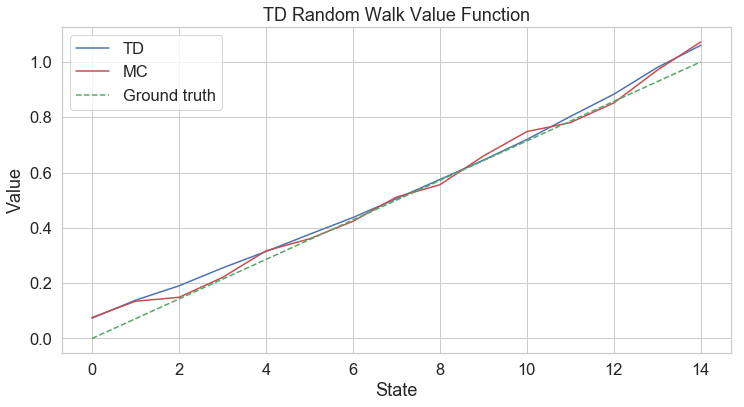

In [6]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(12, 6))
plt.plot(states, td_values, 'b-', states, mc_values, 'r-', states, true_values, 'g--')
plt.title('TD Random Walk Value Function')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(['TD', 'MC', 'Ground truth'])
plt.show()

As we can see, both algorithms reach a good approximation of the true value function after 5000 episodes. But how can we compare the two quantitatively? A common metric is the root mean squared error (RMSE). At any given episode, both algorithms have an estimate of the value function, $\hat{v}_{\pi}$. Knowing the true value function $v_{\pi}$, we can compute

$$
RMSE = \sqrt{\frac{1}{\lvert \mathscr{S} \rvert} \sum_{s \in \mathscr{S}} \left[v_{\pi}(s) - \hat{v}_{\pi}(s)\right]^2}
$$

where $\mathscr{S}$ is the state space, whose size is given by $\lvert \mathscr{S} \rvert$. That is, for every state, we compute the squared difference between our value estimate and the true value, add them all up, divide by the number of states, and take the square root. The closer $\hat{v}_{\pi}$ is to the true value function, the smaller the RMSE.

Next, let's implement this using RL Suite. First, we'll define a function computes the quantity above.

In [7]:
def rmse(vf):
    """Compute the RMSE of some value function."""
    se = [(true_values[s] - vf(get_obs(s)).numpy().item()) ** 2 for s in range(NUM_STATES)]
    return np.sqrt(np.sum(se))

Then we will run the two algorithms once again, but only 100 episodes at a time. This can simply be done by using the same `value_fn` object each time we call the algorithm. We'll define two methods that do this for us.

In [8]:
run_td_iteration = lambda value_fn, num_episodes: semi_gradient_td_prediction(
    env_fn=lambda: gym.make(ENV), policy=random_policy, value_fn=value_fn,
    alpha=ALPHA, gamma=GAMMA, num_episodes=num_episodes,
    data_dir='/tmp/tests/random_walk_td_2', seed=SEED
)

run_mc_iteration = lambda value_fn, num_episodes: gradient_mc_prediction(
    env_fn=lambda: gym.make(ENV), policy=random_policy, value_fn=value_fn,
    alpha=ALPHA, gamma=GAMMA, num_episodes=num_episodes,
    data_dir='/tmp/tests/random_walk_mc_2', seed=SEED
)

And then we initialize the value functions and run 10 iterations of each procedure. After each iteration, we'll compute the RMSE. Note that the total number of episodes will be less than the 5000 we ran above, so we may not be close to convergence at the end.

In [9]:
NUM_ITERATIONS = 10
EPISODES_PER_ITERATION = 100
iterations = range(NUM_ITERATIONS)

In [10]:
td_value_fn = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(NUM_STATES,), activation='linear')])
td_rmse = []
print('%-15s %-15s' % ('Iteration', 'RMSE'))
for i in iterations:
    run_td_iteration(td_value_fn, EPISODES_PER_ITERATION)
    error = rmse(td_value_fn)
    td_rmse.append(error)
    print('%-15d %-15.2f' % (i, error))

Iteration       RMSE           
0               1.62           
1               1.23           
2               1.03           
3               0.88           
4               0.76           
5               0.66           
6               0.59           
7               0.53           
8               0.48           
9               0.45           


In [11]:
mc_value_fn = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(NUM_STATES,), activation='linear')])
mc_rmse = []
print('%-15s %-15s' % ('Iteration', 'RMSE'))
for i in iterations:
    run_td_iteration(mc_value_fn, EPISODES_PER_ITERATION)
    error = rmse(mc_value_fn)
    mc_rmse.append(error)
    print('%-15d %-15.2f' % (i, error))

Iteration       RMSE           
0               1.45           
1               1.16           
2               1.00           
3               0.87           
4               0.76           
5               0.66           
6               0.58           
7               0.52           
8               0.47           
9               0.43           


Finally, we can plot the results.

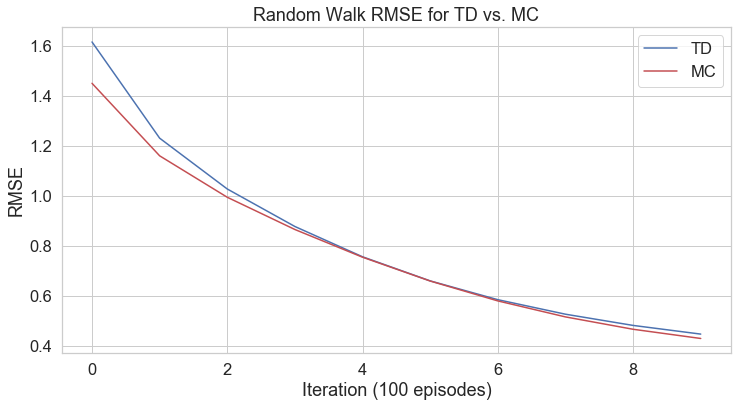

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(iterations, td_rmse, 'b-', iterations, mc_rmse, 'r-')
plt.title('Random Walk RMSE for TD vs. MC')
plt.xlabel('Iteration (%d episodes)' % EPISODES_PER_ITERATION)
plt.ylabel('RMSE')
plt.legend(['TD', 'MC'])
plt.show()

We can see that the Monte Carlo prediction algorithm appears to converge a bit faster than TD-based one. Why is this? For one, this could just be a coincidence. We only ran the experiment a single time here, and results in RL tend to have fairly high variance. Another possibility is that the learning rate $\alpha$ we used is better suited for the Monte Carlo approach.

But perhaps it is not a coincidence. One hypothesis that could explain these results is the nature of the problem favors the value function update used in the MC algorithm. There is only a single reward in the entire problem setting, which occurs at the very end of the episode. Each update done in MC prediction includes this reward, since we are updating towards the whole episode's return. On the other hand, TD prediction will only update the state adjacent to the goal in the first episode, since all updates are based on neighboring states. Thus, it will take a while for the reward to propagate towards other states, especially considering the small learning rate. As a result, the MC approach might more quickly approach the true value function.

In general, there is a bias-variance tradeoff between TD and MC methods. Since MC updates always use the observed return as a target, they are completely unbiased. But since the policy we want to learn (and typically also the environment) is stochastic, there is lots of noise in this signal. On the other hand, the TD target is much more stable because we are updating towards our own value function estimates, which are not changing so quickly over time. However, these updates are biased because our estimates are not always accurate.

## Conclusion

We saw introduced two popular algorithms in reinforcement learning and showed how to implement them in Python with TensorFlow 2.0. We also demonstrated how to use RL Suite in order to compute custom metrics for an algorithm, and compared the RMSE of our two algorithms on the Random Walk task. For further reading, we recommend

- [Making Sense of the Bias Variance Tradeoff in Deep RL](https://medium.com/mlreview/making-sense-of-the-bias-variance-trade-off-in-deep-reinforcement-learning-79cf1e83d565)
- [RL Course by David Silver - Lecture 4: Model-Free Prediction](https://www.youtube.com/watch?v=PnHCvfgC_ZA)
- [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html), Chapters 5 and 6

## References

- Sutton, R. S., Barto, A. G. (2018). [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html). The MIT Press.